In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# MT-Bench Human Annotation Dataset

In [2]:
splits = {'gpt4_pair': 'data/gpt4_pair-00000-of-00001-c0b431264a82ddc0.parquet', 
          'human': 'data/human-00000-of-00001-25f4910818759289.parquet'}

human_df = pd.read_parquet("hf://datasets/lmsys/mt_bench_human_judgments/" + splits["human"])
gpt_df = pd.read_parquet("hf://datasets/lmsys/mt_bench_human_judgments/" + splits["gpt4_pair"])

In [3]:
def standardize_models(row):
    if row["model_a"] > row["model_b"]:
        row["model_a"], row["model_b"] = row["model_b"], row["model_a"]
    return row

# Apply the standardization to both dataframes
human_df = human_df.apply(standardize_models, axis=1)
gpt_df = gpt_df.apply(standardize_models, axis=1)

human_df["conversation_a"] = human_df["conversation_a"].apply(str)
human_df["conversation_b"] = human_df["conversation_b"].apply(str)
gpt_df["conversation_a"] = gpt_df["conversation_a"].apply(str)
gpt_df["conversation_b"] = gpt_df["conversation_b"].apply(str)

In [4]:
merge_columns = ["question_id", "model_a", "model_b", "conversation_a", "conversation_b", "turn"]

merged_df = pd.merge(
    human_df,
    gpt_df,
    on=merge_columns,
    suffixes=("_human", "_gpt4")
)

# Drop the 'judge_human' and 'judge_gpt4' columns
merged_df = merged_df.drop(columns=['judge_human', 'judge_gpt4'], axis=1)

merged_df = merged_df[['question_id', 'model_a', 'model_b', 'winner_human', 'winner_gpt4', 'conversation_a', 'conversation_b', 'turn']]

In [5]:
def encode_winner(winner):
    if pd.isna(winner):
        return 2  # Handle NaN values
    elif winner == 'model_a':
        return 0
    elif winner == 'model_b':
        return 1
    else:  # 'tie' or 'tie (inconsistent)'
        return 2

In [6]:
# Function to calculate agreement between human and model judgments
def calculate_agreement(df, label_col_1='winner_human_encoded', label_col_2='winner_gpt4_encoded'):
    valid_df = df[(df[label_col_1] != 2) & (df[label_col_2] != 2)]
    agreement = np.mean(valid_df[label_col_1] == valid_df[label_col_2])
    return agreement

In [7]:
def adjust_with_control_variates(df, gold_label='winner_human_encoded', 
                                  gpt_label='winner_gpt4_encoded', 
                                  tau=None):
    # Remove NaN and tie labels
    non_tie_df = df[
        (df[gold_label] != 2) & 
        (df[gpt_label] != 2) & 
        (~df[gold_label].isna()) & 
        (~df[gpt_label].isna())
    ]
    
    # If tau not provided, calculate mean of LLM labels
    if tau is None:
        tau = non_tie_df[gpt_label].mean()
    
    covariance_m_t = np.cov(non_tie_df[gold_label], non_tie_df[gpt_label])[0, 1]
    var_t = non_tie_df[gpt_label].var()
    
    # Compute control variate coefficient
    c_star = -covariance_m_t / var_t if var_t != 0 else 0
    
    # Create copy of dataframe to modify
    adjusted_df = df.copy()
    
    # Adjust only non-tie, non-NaN labels
    mask = (
        (adjusted_df[gold_label] != 2) & 
        (adjusted_df[gpt_label] != 2) & 
        (~adjusted_df[gold_label].isna()) & 
        (~adjusted_df[gpt_label].isna())
    )
    
    adjusted_df.loc[mask, 'adjusted_gold_label'] = (
        adjusted_df.loc[mask, gold_label] + 
        c_star * (adjusted_df.loc[mask, gpt_label] - tau)
    )
    
    # For tie or NaN labels, keep the original label
    adjusted_df.loc[~mask, 'adjusted_gold_label'] = adjusted_df.loc[~mask, gold_label]
    
    return adjusted_df

In [8]:
def encode_data(df):
    df['winner_human_encoded'] = df['winner_human'].apply(encode_winner)
    df['winner_gpt4_encoded'] = df['winner_gpt4'].apply(encode_winner)
    return df


Baseline Agreement: 0.8559928443649374

Analyzing sample size: 43

Analyzing sample size: 52

Analyzing sample size: 61

Analyzing sample size: 70

Analyzing sample size: 78

Analyzing sample size: 87

Analyzing sample size: 96

Analyzing sample size: 105

Analyzing sample size: 113

Analyzing sample size: 122

Analyzing sample size: 131

Analyzing sample size: 140

Analyzing sample size: 149

Analyzing sample size: 157

Analyzing sample size: 166

Analyzing sample size: 175

Analyzing sample size: 184

Analyzing sample size: 192

Analyzing sample size: 201

Analyzing sample size: 210

Analyzing sample size: 219

Analyzing sample size: 227

Analyzing sample size: 236

Analyzing sample size: 245

Analyzing sample size: 254

Analyzing sample size: 262

Analyzing sample size: 271

Analyzing sample size: 280

Analyzing sample size: 289

Analyzing sample size: 298

Analyzing sample size: 306

Analyzing sample size: 315

Analyzing sample size: 324

Analyzing sample size: 333

Analyzing samp

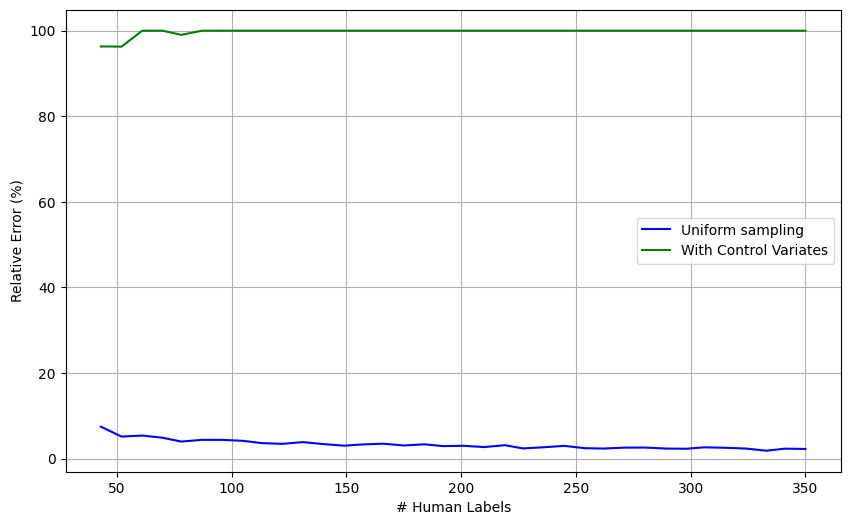

Number of samples: 43, Average Relative Error (Without Control Variates): 7.460502147752185%, Avg Relative Error (Control Variates): 96.32613606743864%
Number of samples: 52, Average Relative Error (Without Control Variates): 5.141118455867343%, Avg Relative Error (Control Variates): 96.28654633550639%
Number of samples: 61, Average Relative Error (Without Control Variates): 5.393244800122205%, Avg Relative Error (Control Variates): 100.0%
Number of samples: 70, Average Relative Error (Without Control Variates): 4.866935399803461%, Avg Relative Error (Control Variates): 100.0%
Number of samples: 78, Average Relative Error (Without Control Variates): 3.9764048407416386%, Avg Relative Error (Control Variates): 99.0280459770115%
Number of samples: 87, Average Relative Error (Without Control Variates): 4.378137069016223%, Avg Relative Error (Control Variates): 100.0%
Number of samples: 96, Average Relative Error (Without Control Variates): 4.379319659067757%, Avg Relative Error (Control Va

In [9]:
def main_analysis(df):
    df = encode_data(df)
    
    # Calculate baseline agreement
    agreement_human = calculate_agreement(df)
    print(f"\nBaseline Agreement: {agreement_human}")
    
    # Compute relative error
    llm_relative_error = abs(calculate_agreement(df, 'winner_gpt4_encoded', 'winner_human_encoded') - agreement_human) / agreement_human
    # print(f"\nLLM Relative Error: {llm_relative_error}")

    # Sampling rates
    sampling_rates = np.arange(0.025, 0.205, 0.005)
    n_samples = (sampling_rates * len(df)).astype(int)
    
    np.random.seed(42)
    
    # Compute relative errors for uniform sampling
    avg_relative_errors = []
    avg_relative_errors_control_variates = []
    
    for n in n_samples:
        print(f"\nAnalyzing sample size: {n}")
        
        # Uniform sampling errors
        relative_errors = []
        for i in range(100):
            random_indices = np.random.choice(len(df), size=n)
            sampled_df = df.iloc[random_indices]
            
            sample_agreement = calculate_agreement(sampled_df)
            relative_error = abs(sample_agreement - agreement_human) / agreement_human * 100
            relative_errors.append(relative_error)
        
        avg_relative_errors.append(np.mean(relative_errors))
        
        # Control variates errors
        relative_errors_control_variates = []
        for i in range(100):
            random_indices = np.random.choice(len(df), size=n)
            sampled_df = df.iloc[random_indices]
            
            adjusted_sampled_df = adjust_with_control_variates(sampled_df)
            
            sample_agreement_control_variates = calculate_agreement(
                adjusted_sampled_df, 
                label_col_1='adjusted_gold_label',
                label_col_2='winner_gpt4_encoded'
            )
            
            relative_error_control_variate = abs(
                sample_agreement_control_variates - agreement_human
            ) / agreement_human * 100
            relative_errors_control_variates.append(relative_error_control_variate)
        
        avg_relative_errors_control_variates.append(np.mean(relative_errors_control_variates))

    # Plotting and output
    plt.figure(figsize=(10, 6))
    plt.plot(n_samples, avg_relative_errors, '-', color='blue', label='Uniform sampling')
    plt.plot(n_samples, avg_relative_errors_control_variates, '-', color='green', label='With Control Variates')
    plt.xlabel('# Human Labels')
    plt.ylabel('Relative Error (%)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print detailed results
    for n, error_no_ctrl, error_ctrl in zip(n_samples, avg_relative_errors, avg_relative_errors_control_variates):
        print(f"Number of samples: {n}, Average Relative Error (Without Control Variates): {error_no_ctrl}%, Avg Relative Error (Control Variates): {error_ctrl}%")

main_analysis(merged_df)